In [15]:
!pip install --upgrade --force-reinstall --no-deps kaggle -qqq
!pip install torchsummaryX -qqq
!pip install colorama -qqq
!pip install wandb -qqq

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!mkdir /root/.kaggle/
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json" /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [18]:
# !rm -rf /content/dataset
!mkdir /content/dataset

In [19]:
!kaggle competitions download petfinder-pawpularity-score -p /content/dataset

 99% 971M/983M [00:37<00:00, 30.3MB/s]
100% 983M/983M [00:37<00:00, 27.2MB/s]


In [20]:
!unzip  -n -qqq dataset/petfinder-pawpularity-score.zip -d dataset/

In [21]:
import os
files = os.listdir("/content/dataset/train")
print(len(files))

9912


In [22]:
import os
import gc
import glob

from skimage import io
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision 
from torchvision import transforms

from PIL import Image
from torchvision.io import read_image
from sklearn.model_selection import StratifiedKFold
import torchvision.models as models
import torch.nn.functional as F
from torchsummaryX import summary
import torch.optim as optim
import random
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import time
from datetime import datetime
from pytz import timezone
from google.colab import output

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

# CFG

In [24]:
class CFG:
    """Config class, having params for traning & meta infomation"""

    use_checkpoint = True
    
    epoch = 300
    batch_size = 16
    n_fold = 5
    n_accumulate = 1
    num_works = 0
    
    
    # early stoping
    patience = 30
    delta = 0.3

    # optimizer
    weight_decay = 1e-6
    lr = 1e-5

    # scheduler
    min_lr = 1e-6
    T_max = 100

    target_col = "Pawpularity"
    use_wandb = True

    seed = 42
    project_name = "petfinder-project"
    SAVEPATH = "/content/drive/MyDrive/Colab Notebooks/petfinder/save/"
    DATAPATH = "/content/dataset/"

    time = datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H_%M_%S')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
if CFG.use_wandb:
    import wandb
    wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)
np.random.seed(CFG.seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(CFG.seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if CFG.device == 'cuda':
    torch.cuda.manual_seed_all(CFG.seed)

print(CFG.device)

cuda:0


## wandb login

In [27]:
wandb_config = dict()

for key, value in CFG.__dict__.items():
    if "__" not in key:
        wandb_config[key] = value
# wandb_config

In [28]:
if CFG.use_wandb:
    run = wandb.init(name = CFG.time, project=CFG.project_name, entity="findyourfit",config = wandb_config)

wandb: Currently logged in as: findyourfit (use `wandb login --relogin` to force relogin)


In [29]:
train_images = os.listdir(CFG.DATAPATH+"train/")
test_images = os.listdir(CFG.DATAPATH+"test/")

In [30]:
# df = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df = pd.read_csv(CFG.DATAPATH+"train.csv")

In [31]:
df[["Id","Pawpularity"]].head()

,Id,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,63
1,0009c66b9439883ba2750fb825e1d7db,42
2,0013fd999caf9a3efe1352ca1b0d937e,28
3,0018df346ac9c1d8413cfcc888ca8246,15
4,001dc955e10590d3ca4673f034feeef2,72


In [32]:
io.imread(CFG.DATAPATH+"train/"+df["Id"].values[0]+".jpg").shape

(720, 405, 3)

# Transform

In [33]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# K-fold

In [34]:
df = pd.read_csv(CFG.DATAPATH+"train.csv")
# train = train_df.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [35]:
num_bins = int(np.floor(1 + np.log2(len(df))))
df["bins"] = pd.cut(df[CFG.target_col], bins=num_bins, labels=False)

In [36]:
Fold = StratifiedKFold(n_splits=CFG.n_fold,shuffle=True,random_state=CFG.seed)

In [37]:
for n,(train_index, val_index) in enumerate(Fold.split(df,df["bins"])):
    df.loc[val_index,'fold'] = int(n)
df["fold"] = df["fold"].astype(int)

# DATA CLASS

In [38]:
from tqdm.auto import tqdm
# 이미지 로딩 -> resize
class CuteDataset(Dataset):
    def __init__(self,root_dir,df,transform=None,fold=None):
        """
            image_dir, csv_dir, transform = None
        """
        self.root_dir = root_dir
        
        if transform == None:
            self.transform = transforms.Compose([transforms.ToTensor()])
        else:
            self.transform = transform

        self.df = df
        self.ids = self.df["Id"]
        self.scores = self.df["Pawpularity"]
        
        self.images = []
        for _id in tqdm(self.ids):
            img = Image.open(root_dir+_id+".jpg")
            img = img.resize((224,224))
            self.images.append(img)    

    # def __len__(self):
    #     return len(self.images)
        



    # def __getitem__(self, idx):        
    #     images = self.transform(self.images[idx])

        
    #     return images, self.scores[idx] #, self.Pawpularity    

## Make KFold

In [39]:
train_df = pd.read_csv(CFG.DATAPATH+"train.csv")
# train = train_df.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [40]:
num_bins = int(np.floor(1 + np.log2(len(train_df))))
train_df["bins"] = pd.cut(train_df[CFG.target_col], bins=num_bins, labels=False)

In [41]:
Fold = StratifiedKFold(n_splits=CFG.n_fold,shuffle=True,random_state=CFG.seed)

In [42]:
for n,(train_index, val_index) in enumerate(Fold.split(train_df,train_df["bins"])):
    train_df.loc[val_index,'fold'] = int(n)
train_df["fold"] = train_df["fold"].astype(int)

In [43]:
# display(train.groupby(["fold","bins"]).size())

In [44]:
class FoldDataset(Dataset):
    def __init__(self,DataClass,fold=None,transform=None):
        """
        fold = None -> total
        fold != None &
            isTraining = True -> return n-1 fold
            isTraining = False -> return 1 fold  # return validation set

        """        
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor()])
        else:
            self.transform = transform

        self.df = DataClass.df
        self.ids = self.df["Id"]
        self.scores = self.df["Pawpularity"]
        self.idx = self.df[self.df["fold"] == fold].index

        self.images = [DataClass.images[idx] for idx in self.idx]
        
        # image -> 원본 에서 idx 필터링
        # 라벨 -> 필터링된 df -> 한번더 필터링 
        # = 에러
        
    
    def __len__(self):
        return len(self.idx)
    
    def __getitem__(self, idx):        
        # images = self.transform(self.images[idx])
        images = self.transform(self.images[idx])
        scores = self.scores[idx]

        
        return images, scores #, self.Pawpularity
                
        
        

In [45]:
train_dataset = CuteDataset(root_dir=CFG.DATAPATH+"train/", df = df,transform=transform_train)

  0%|          | 0/9912 [00:00<?, ?it/s]

# View Target's distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81a43b5710>]],
      dtype=object)

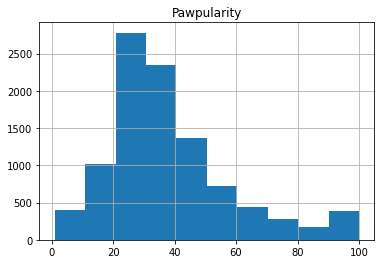

In [46]:
train_df[["Pawpularity"]].hist()

In [47]:
train_log = np.log2(train_df["Pawpularity"])

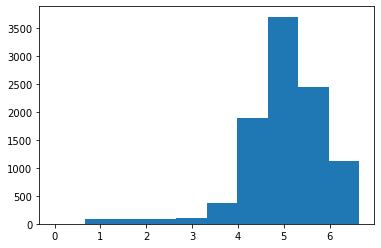

In [48]:
plt.hist(train_log)
plt.show()

In [49]:
from scipy.stats import skew, kurtosis

# 왜도
print("왜도 : ", skew(train_log))

# 첨도
print("첨도 : ", kurtosis(train_log))

왜도 :  -1.3735703243811932
첨도 :  4.430919737645768


# Make model 

자세한 설명 from [here](https://gaussian37.github.io/dl-concept-resnet/)

- identity : 입력을 출력과 더해주는 형태
    - skip connection의 구조로 feature를 추출하기 전 후를 더하는 특징

In [51]:
model = models.resnet50(pretrained=True)
model.to(CFG.device)


model.fc = nn.Linear(2048,1,bias=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [52]:
model_summary = summary(model.to("cuda"),torch.zeros((1,3,224,224),dtype = torch.float).to("cuda"))
output.clear()

In [53]:
model_summary

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[3, 64, 7, 7]","[1, 64, 112, 112]",9408.0,118013952.0
1_bn1,[64],"[1, 64, 112, 112]",128.0,64.0
2_relu,-,"[1, 64, 112, 112]",NaN,NaN
3_maxpool,-,"[1, 64, 56, 56]",NaN,NaN
4_layer1.0.Conv2d_conv1,"[64, 64, 1, 1]","[1, 64, 56, 56]",4096.0,12845056.0
...,...,...,...,...
153_layer4.2.Conv2d_conv3,"[512, 2048, 1, 1]","[1, 2048, 7, 7]",1048576.0,51380224.0
154_layer4.2.BatchNorm2d_bn3,[2048],"[1, 2048, 7, 7]",4096.0,2048.0
155_layer4.2.ReLU_relu,-,"[1, 2048, 7, 7]",NaN,NaN


In [54]:
model_summary["Params"].sum(), model_summary["Mult-Adds"].sum()

(23510081.0, 4087164864.0)

- resnet 50
    - parameter 개수 : 약 2400만 ,23510081
    - 연산 횟수 : 약 41억 , 4087164864

## Model freezing
- 2048 -> 1 의 분류기는 너무 단순해서 학습이 되지 않음
    - sol 1: 전이학습한 모델의 weights를 학습 가능하도록 변경함
    - sol 2 : 분류기를 좀 더 복잡하게 만들기 ( 규모 up, # of parameter up)
    

In [55]:
# default : False
cnt = 0
for param in model.parameters():
    cnt += 1
    param.requires_grad = True
print(cnt)

161


- load 후 모드 선택 필수
    - .train() or .eval()
    - 모델 선언시 모드 선택은 저장 X

- RuntimeError: Input type (torch.cuda.LongTensor) and weight type (torch.cuda.FloatTensor) should be the same
    -  from
    ```python
    images = images.long().to(device)
    labels = torch.unsqueeze(labels,1).long().to(device)
    ```
    - to 
    ```python
    images = images.type(torch.FloatTensor).to(device)
    labels = torch.unsqueeze(labels,1).type(torch.FloatTensor).to(device)
    ```
- RuntimeError: Found dtype Long but expected Float
    ```python
    loss =  criterion(pred.to(torch.float32), y.to(torch.float32))
    ```


- RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
    - data, model 모두 동일한 device에서 실행되어야 한다.
    ```python
    to(deivce)
    ```

- RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument mat1 in method wrapper_addmm)
- RuntimeError: Found dtype Long but expected Float
```python
    X = X.type(torch.FloatTensor).to(device)
    y = y.type(torch.FloatTensor).to(device)
```

- RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

    - from
    ```python
    images.requires_grad, labels.requires_grad
    > False, False

    ```
    - to (with FoldDataset) 
    ```python
    images.require_grad = True
    self.scores[idx] = True

    ```
- AttributeError: 'numpy.int64' object has no attribute 'requires_grad'


- cpu 정보 확인, 캐글
```python
!cat /proc/cpuinfo
```

# DataLoader

In [56]:
fold = 3
df_train = df[df.fold != fold]
df_valid = df[df.fold == fold]

In [57]:
df_valid.shape, df_train.shape

((1982, 16), (7930, 16))

In [58]:
def prepare_loaders(fold):
    # df_train = df[df.fold != fold]
    # df_valid = df[df.fold == fold]
    
    train_fold = FoldDataset(train_dataset,fold=fold)
    val_fold = FoldDataset(train_dataset,fold=fold)
    

    train_loader = DataLoader(train_fold, batch_size=CFG.batch_size, shuffle=False, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(val_fold, batch_size=CFG.batch_size, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

-  ValueError: num_samples should be a positive integer value, but got num_samples=0
> 커스텀 DataSet에 __len__, __getitem__을 만들지 않아서, 빈 fold를 DataLoader에 탑재함
    - 해결책
    ```python
    class FoldDataset(dataset):
        def __len__():
            pass
        def __getitem__():
            pass
    ```


- KeyError: 1
> dataset의 images, targets의 인덱스 불일치
- 해결책 : index를 일치하도록 변경





# DataLoader / Creterion / Optimizer

In [59]:
train_loader, valid_loader = prepare_loaders(fold=0)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=CFG.lr)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)

# Loading from Savepoint

In [60]:
print(CFG.use_checkpoint)
filenames = os.listdir(CFG.SAVEPATH)

# check point 사용 설정하고 & save 폴더에 저장된 모델이 존재 한다면
if CFG.use_checkpoint and os.path.exists(CFG.SAVEPATH): 
    
    checkpoint = torch.load(CFG.SAVEPATH+filenames[0])
    model.load_state_dict(checkpoint['model_state_dict'])
    # train_history = checkpoint['loss_history']
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # checkpoint_epoch = checkpoint['epoch']
    # checkpoint_loss = checkpoint['loss']
    model.eval()
    output.clear()
    print("Start from Checkpoint")
    # plt.plot(train_history)
else:
    print("start from zero")

Start from Checkpoint


# Training per epoch

In [61]:
from torch.autograd import grad
def train_one_epoch(model,optimizer,scheduler,dataloader,device,epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader),total = len(dataloader))
    for step, (images, targets) in bar:
        images = images.to(device, dtype=torch.float)
        targets = torch.unsqueeze(targets.to(device, dtype=torch.float),1)
        images.requires_grad =True
        targets.requires_grad = True

        batch_size = images.size(0)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, targets)
        loss = loss / CFG.n_accumulate

        
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()*CFG.batch_size
        dataset_size += CFG.batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch,Train_Loss=epoch_loss,LR=optimizer.param_groups[0]["lr"])

    gc.collect()

    return epoch_loss    
        


# Validation per epoch

In [62]:
@torch.no_grad()
def valid_one_epoch(model,dataloader, device,epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    TARGETS = []
    PREDS = []

    bar = tqdm(enumerate(dataloader),total=len(dataloader))
    for step, (images,targets) in bar:
        images = images.to(device, dtype=torch.float)
        targets = torch.unsqueeze(targets.to(device,dtype=torch.float),1)

        images.require_grad = True
        targets.require_grad = True

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,targets)
        
        running_loss += loss.item() * CFG.batch_size
        dataset_size += CFG.batch_size

        epoch_loss = running_loss / dataset_size

        PREDS += [outputs.view(-1).cpu().detach().numpy()]
        TARGETS += [targets.view(-1).cpu().detach().numpy()]

        bar.set_postfix(Epoch=epoch,Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])

    TARGETS = np.concatenate(TARGETS)
    PREDS = np.concatenate(PREDS)

    val_rmse = mean_squared_error(TARGETS,PREDS,squared=False)

    gc.collect()

    return epoch_loss, val_rmse


# Run Training

In [63]:
from collections import defaultdict
import copy 

def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    earlystop_cnt = 0
        
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_rmse = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_epoch_loss, val_epoch_rmse = valid_one_epoch(model, valid_loader, 
                                                         device=CFG.device, 
                                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid RMSE'].append(val_epoch_rmse)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid RMSE": val_epoch_rmse})
        
        print(f'Valid RMSE: {val_epoch_rmse}')
        
        # deep copy the model
        if val_epoch_rmse  <= best_epoch_rmse+ CFG.delta:
            earlystop_cnt = 0
            print(f"{c_}Validation Loss Improved ({best_epoch_rmse} ---> {val_epoch_rmse})")
            best_epoch_rmse = val_epoch_rmse
            run.summary["Best RMSE"] = best_epoch_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "RMSE{:.4f}_epoch{:.0f}.bin".format(best_epoch_rmse, epoch)
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'loss_history': history
            }, f"{CFG.SAVEPATH}{CFG.time}best_model.pt") # {CFG.SAVEPATH} , drive 용량 고려 
            #f"{CFG.SAVEPATH}{CFG.time}_RMSE{best_epoch_rmse:.4f}_epoch{epoch:.0f}"
                 
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
        else:
            earlystop_cnt += 1
            print(Fore.RED+Style.BRIGHT+f"Early stopped counted {earlystop_cnt}"+Style.RESET_ALL)

            if earlystop_cnt >= CFG.patience:
                print(Back.WHITE + Fore.RED + Style.BRIGHT + " Early Stopped !! " + Style.RESET_ALL)
                return model, history

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best RMSE: {:.4f}".format(best_epoch_rmse))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Training with K-Fold

In [64]:
# train_history = defaultdict(list)

# for fold in range(CFG.n_fold):
#     train_loader, valid_loader = prepare_loaders(fold=fold)
#     model, history = run_training(model, optimizer, scheduler, CFG.device, CFG.epoch)
#     train_history['Train Loss'].append(history['Train Loss'])
#     train_history['Valid Loss'].append(history['Valid Loss'])
#     train_history['Valid RMSE'].append(history['Valid RMSE'])

# training with training set & validation set (0.8 : 0.2)

In [ ]:
model, train_history = run_training(model, optimizer, scheduler, CFG.device, CFG.epoch)

In [66]:
wandb.finish()

Train Loss,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▆▇▃▃▆▅▃▅▆▇▄▄▄▄▂▃▅▅▃▃▃▃▄▅▃▂▂▂▃▁▃▁▃▂▃▂▂▂▂
Valid RMSE,█▆▇▃▃▆▅▄▅▆▇▄▄▄▄▂▃▅▆▃▃▃▄▄▅▃▂▂▂▃▁▃▁▃▂▃▂▂▂▂
Best RMSE,7.17603
Train Loss,0.10059
Valid Loss,51.66178
Valid RMSE,7.17603


# Saving a last model 
- not mean best model

In [67]:
torch.save({
            'epoch': CFG.epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict(),
            'loss_history': train_history
            }, f"{CFG.SAVEPATH}{CFG.time}last_model.pt")

In [68]:
from google.colab import files

files.download(f"{CFG.SAVEPATH}{CFG.time}last_model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
CFG.time

'2022-03-18 09_51_24'